Epoch: 0, Train acc: 0.07791666666666666, Test acc: 0.0741
Epoch: 1, Train acc: 0.5673, Test acc: 0.5736
Epoch: 2, Train acc: 0.7468166666666667, Test acc: 0.7472
Epoch: 3, Train acc: 0.8262, Test acc: 0.8215
Epoch: 4, Train acc: 0.8777833333333334, Test acc: 0.8757
Epoch: 5, Train acc: 0.8853166666666666, Test acc: 0.8881
Epoch: 6, Train acc: 0.8998166666666667, Test acc: 0.8938
Epoch: 7, Train acc: 0.90135, Test acc: 0.8948
Epoch: 8, Train acc: 0.9179666666666667, Test acc: 0.9139
Epoch: 9, Train acc: 0.92335, Test acc: 0.9168
Epoch: 10, Train acc: 0.9238666666666666, Test acc: 0.9152
Epoch: 11, Train acc: 0.9237833333333333, Test acc: 0.9156
Epoch: 12, Train acc: 0.9327833333333333, Test acc: 0.9231
Epoch: 13, Train acc: 0.9355833333333333, Test acc: 0.9269
Epoch: 14, Train acc: 0.9378, Test acc: 0.9288
Epoch: 15, Train acc: 0.9344666666666667, Test acc: 0.9264
Epoch: 16, Train acc: 0.9393, Test acc: 0.9283
Epoch: 17, Train acc: 0.9365166666666667, Test acc: 0.9237
Epoch: 18, Train 

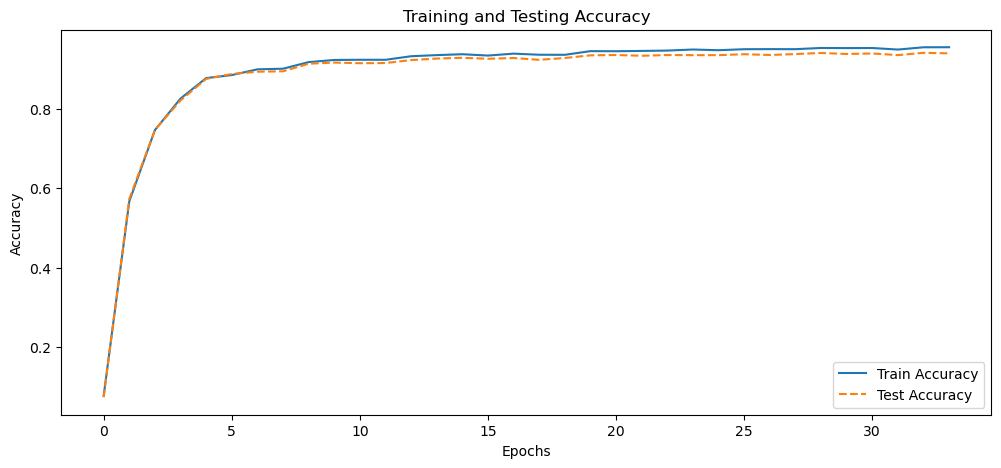

In [48]:
import sys
import os
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.optimizer import SGD
from common.layers import *

class MultiLayerNet:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_std='He'):
        self.params = {}
        self.layers = OrderedDict()
        
        # layer_sizes를 인스턴스 변수로 저장
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(1, len(self.layer_sizes)):
            weight_std = np.sqrt(2. / self.layer_sizes[i-1]) if weight_init_std == 'He' else np.sqrt(1. / self.layer_sizes[i-1])
            self.params['W' + str(i)] = weight_std * np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
            self.params['b' + str(i)] = np.zeros(self.layer_sizes[i])
            self.layers['Affine' + str(i)] = Affine(self.params['W' + str(i)], self.params['b' + str(i)])
            
            if i < len(self.layer_sizes) - 1:
                self.layers['Relu' + str(i)] = Relu()
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])
        
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for i in range(1, len(self.layer_sizes)):
            grads['W' + str(i)] = self.layers['Affine' + str(i)].dW
            grads['b' + str(i)] = self.layers['Affine' + str(i)].db
        
        return grads

# 데이터 로딩
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터 설정
iters_num = 10000
batch_size = 200
learning_rate = 0.018

# 은닉 계층 크기를 15로 고정 (5개 계층)
hidden_sizes = [15, 15, 15, 15, 15, 10, 10]

# 모델 초기화
network = MultiLayerNet(input_size=784, hidden_sizes=hidden_sizes, output_size=10)

# 최적화기 설정
optimizer = SGD(lr=learning_rate)

# 학습 진행
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_indices = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_indices]
    t_batch = t_train[batch_indices]
    
    grad = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grad)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"Epoch: {int(i / iter_per_epoch)}, Train acc: {train_acc}, Test acc: {test_acc}")

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label='Train Accuracy')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label='Test Accuracy', linestyle='--')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
